In [ ]:
import sys
sys.path.append('/content/drive/My Drive/HSMC-ECS')
#sys.path.insert(0,'/content/drive/MyDrive/HSMC-ECS')
#%cd /content/drive/MyDrive/HSMC-ECS
import global_vars as glob # To check.

> f = 1.83
> Dataset 0.
> Uploading data from file 'echoed_ramsey_data[0.2,10[df=1.83_sched=75_nshots=5_2.data'...
Data vector: [(0.19999999999999998, 0), (0.19999999999999998, 0), (0.19999999999999998, 1), (0.19999999999999998, 0), (0.19999999999999998, 0), (0.3324324324324324, 0), (0.3324324324324324, 0), (0.3324324324324324, 0), (0.3324324324324324, 0), (0.3324324324324324, 0), (0.4648648648648649, 1), (0.4648648648648649, 1), (0.4648648648648649, 0), (0.4648648648648649, 1), (0.4648648648648649, 1), (0.5972972972972974, 1), (0.5972972972972974, 1), (0.5972972972972974, 1), (0.5972972972972974, 1), (0.5972972972972974, 1), (0.7297297297297298, 0), (0.7297297297297298, 1), (0.7297297297297298, 0), (0.7297297297297298, 0), (0.7297297297297298, 0), (0.8621621621621622, 0), (0.8621621621621622, 0), (0.8621621621621622, 0), (0.8621621621621622, 0), (0.8621621621621622, 0), (0.9945945945945948, 0), (0.9945945945945948, 1), (0.9945945945945948, 0), (0.9945945945945948, 0), (0.9945945945945

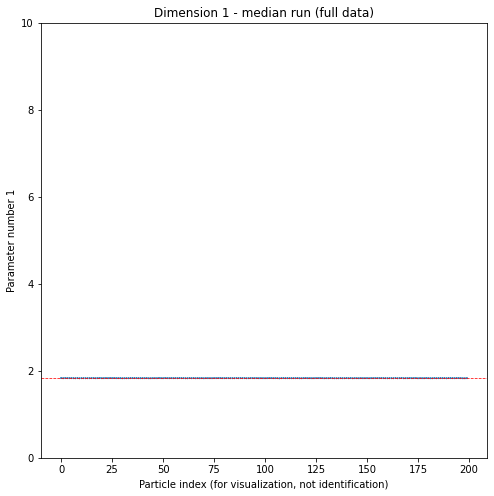

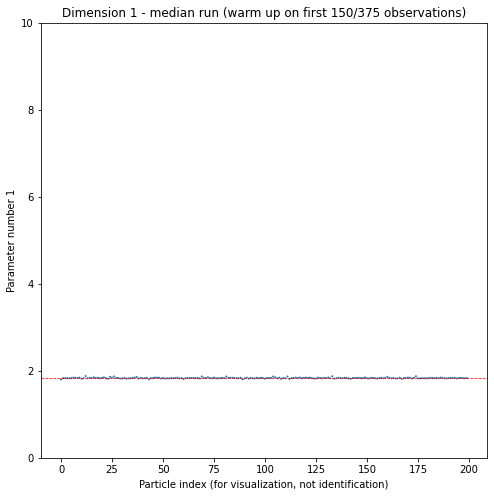

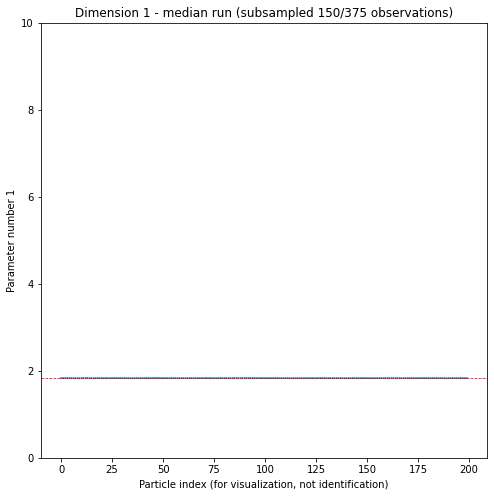

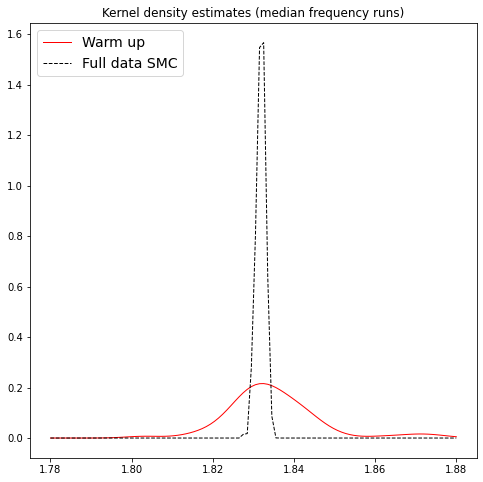

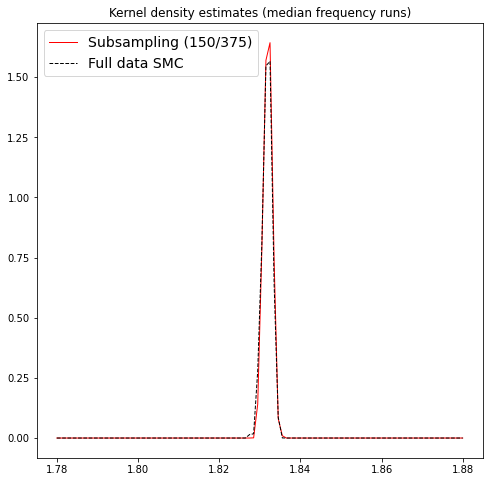

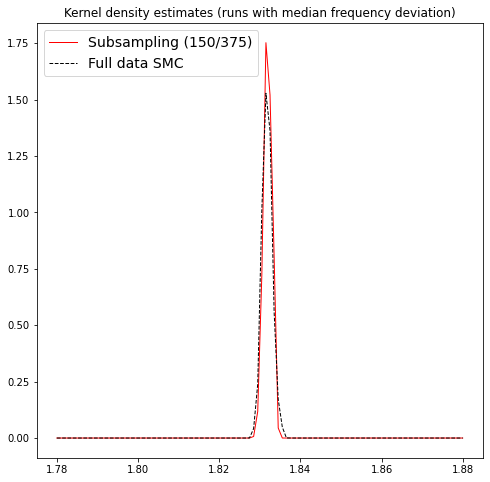

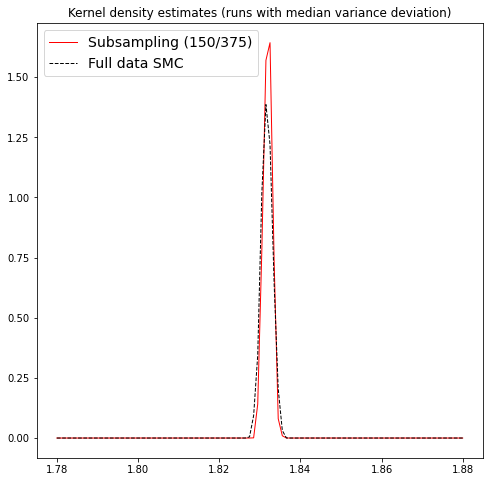

In [ ]:
# -*- coding: utf-8 -*-
"""
!! Despite the name works for random walk Metropolis, so newest version mostly 
tested with HMCthreshold=1. HMC does no better and is slower

Performs inference on the frequencies of a multi-parameter binomial probability
distribution with success probability given by a sum of squared cosines: 
sum_i [ cos(theta_i*t/2)^2 ], using tempered likelihood SMC and optionally 
subsampling a fraction of the observations (for both the weight updates and 
resampling steps).

A sequential Monte Carlo approximation is used to represent the probability 
distributions, using Hamiltonian Monte Carlo and Metropolis-Hastings mutation 
steps.

If subsampling, "energy conserving subsampling HMC" is used; this is achieved 
by wrapping the HMC transitions in a Gibbs update, in which a Metropolis-
-Hastings step is used to pick the subsampling indices (conditioned on the 
latest particle location) before the usual HMC (or gaussian-proposal MH) step 
(conditioned on the indices).

This amounts to a pseudo-marginal approach where the posterior is augmented to
include some auxiliary variables, in this case are the subsampling indices. The
extended target density (encompassing the indices) is left invariant by  the
"composite" Markov transition.

The HMC moves preserve the energy because  the MH acceptance/rejection step 
targets precisely the energy according to which the Hamiltonian dynamics are 
simulated, guaranteeing correctness. As such, marginalizing over the indices 
should yield parameter samples that abide by the target distribution.

The target distributions consist of a sequence of annealed likelihoods, i.e. 
the likelihood resulting from the whole data set, raised to the power of some 
annealing coefficients.

Estimators are used for the likelihood, optionally using control variates 
(though they are Taylor approximation based and only work under unimodality,
and so aren't suitable for the chosen target if the parameter vector dimension 
is >=2 unless its components aren't by the model's construction all the same).

The particle positions are plotted, as well as kernel density estimates for the 
final full data and subsampling distributions if both strategies are performed
and the parameter vector is one-dimensional.

Based on "Hamiltonian Monte Carlo with Energy Conserving Subsampling"
[https://arxiv.org/pdf/1402.4102.pdf]
and "Subsampling Sequential Monte Carlo for Static Bayesian Models"
[https://arxiv.org/pdf/1805.03317.pdf]
"""

import pickle, importlib, sys, copy, warnings
import random, numpy as np
import global_vars as glob
from function_evaluations.likelihoods import measure, likelihood, \
    init_likelihoods
from function_evaluations.estimators import Taylor_coefs,likelihood_estimator
from tools.resampler import init_resampler, HMC_resampler, \
    print_resampler_stats
from tools.statistics import SMCparameters, print_info, plot_kdes, plot_kde
from tools.distributions import plot_particles, generate_prior, \
    sum_distributions, init_distributions
warnings.simplefilter("default") # error, ignore, default, always, once
np.seterr(all='warn'); np.seterr(under='ignore')
reload = True
if reload:
    importlib.reload(sys.modules["global_vars"])
    importlib.reload(sys.modules["function_evaluations.likelihoods"])
    importlib.reload(sys.modules["function_evaluations.estimators"])
    importlib.reload(sys.modules["tools.resampler"])
    importlib.reload(sys.modules["tools.statistics"])
    importlib.reload(sys.modules["tools.distributions"])

glob.dim = 1
glob.lbound = 0*np.ones(glob.dim) # The left boundaries for the parameters.
glob.rbound = 10*np.ones(glob.dim) # The right boundaries for the parameters.
        
first_bayes_update = True
def bayes_update(data, distribution, coef, previous_coef, threshold,
                 subsample, control_variates, prev_data,
                 signal_resampling=False,
                 HMCthreshold=1):
    '''
    Updates a prior distribution according to the outcome of a measurement, 
    using Bayes' rule. 
    
    Parameters
    ----------
    data: [([float],int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle the parameter vector (as a bit string)
        The prior distribution (SMC approximation).
    coef: float
        The tempering coefficient corresponding to the current iteration (i.e.
        the one determining the target distribution of the current SMC step).
    previous_coef: float
        The tempering coefficient corresponding to the previous iteration (i.e.
        the one that determined the target distribution of the preceding SMC 
        step, which is approximated by the pre-update particle cloud given by
        `distribution`).
    threshold: float
        The threshold effective sample size that should trigger a resampling 
        step. 
    subsample: bool
        Whether to subsample.
    control_variates: bool
        Whether to use control variates (Taylor approximations of each datum's
        likelihood, yielding a difference estimator with a smaller variance).
    signal_resampling: bool
        Whether to return a second variable denoting the ocurrence of 
        resampling.    
        
    Returns
    -------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle the parameter vector (as a bit string)
        The updated distribution (SMC approximation).
    resampled: bool
        Whether resampling has occurred.
    '''
    global first_bayes_update
    if first_bayes_update is True:
        print("Bayes update: resampling threshold = ", threshold)
        first_bayes_update = False
    acc_weight, acc_squared_weight = 0, 0
    mean = SMCparameters(distribution,stdev=False)
    if subsample:
        print( " -- Distribution mean currently at %.6f." % mean[0])
        if np.isnan(mean[0]):
            print("> Mean is NaN, probably due to all-zero weights." 
                  "Interrupting process... [bayes_update]")
            return distribution, False
        Tcoefs = Taylor_coefs(data,mean)
    # Perform a correction step by re-weighting the particles according to 
    #the last chunk of data added (i.e. to the ratio between the latest 
    #cumulative likelihood to the previous one, which cancels out all but those 
    #newest data).
    for key in distribution: 
        particle = np.frombuffer(key,dtype='float64')
        weight,u = distribution[key]
        if subsample:
            if prev_data is None:
              L = likelihood_estimator(data,particle,[coef,previous_coef],u,mean,
                                      Tcoefs,control_variates=control_variates)
            else:
              Lnew = likelihood_estimator(data,particle,coef,u,mean,
                                      Tcoefs,control_variates=control_variates)
              Lold = likelihood(prev_data,particle,coef=previous_coef)
              L = Lnew/Lold
              # print("old: ", Lold)
              # print("new: ", Lnew)
              # print("exact new: ", likelihood(data,particle,coef=coef))
              # print("prev_weight: ", weight)
        else: 
            L = likelihood(data,particle,coef=coef-previous_coef)
            
        new_weight = L*weight
        distribution[key][0] = new_weight
        acc_weight += new_weight

    if acc_weight==0:
        print("> All zero weights after update. [bayes_update]")
        
    # Normalize the weights.
    for key in distribution:
        w = distribution[key][0]/acc_weight
        distribution[key][0] = w
        acc_squared_weight += w**2 # The inverse participation ratio will be
        #used to decide whether to resample.
        
    resampled = False
    if (1/acc_squared_weight <= threshold):
        resampled = True
        distribution, success = HMC_resampler(data, distribution, coef, 
                              subsample, control_variates=control_variates,
                              HMCthreshold=HMCthreshold,moves=1)
        if not success: 
            if signal_resampling:
                return distribution, None # Resampling interrupted midway.
            return distribution
    
    if signal_resampling:
        return distribution, resampled

    return distribution

first_offline_estimation = True
def offline_estimation(distribution, data, tempering_coefficients, prev_coef,
                       threshold=float('inf'), subsample=False,
                       control_variates=True, plot_all=False,
                       prev_data=None):
    '''
    Estimates the vector of parameters by defining a set of experiments (times)
    , performing them, and updating a given prior distribution according to the
    outcomes (using Bayesian inference).
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle the parameter vector (as a bit string)
        The prior distribution (SMC approximation).
    measurements: int
        The number of measurements/experiment to be performed.
    tmax: float
        The maximum measurement time to be used; each actual time will be 
        chosen at random between 0 to this value.
    tempering_coefficients: float
        The sequence of tempering coefficients to be used in computing the 
        annealed likelihoods.
    threshold: float, optional
        The threshold effective sample size that should trigger a resampling 
        step when updating the distribution (Default is infinity, equivalent to
        N_particles). 
    subsample: bool, optional
        Whether to subsample (Defalut is False).
    control_variates: bool, optional
        Whether to use control variates (Taylor approximations of each datum's
        likelihood, yielding a difference estimator with a smaller variance)
        (Defalut is False). This is not used unless subsample=True.
    plot_all: bool, optional
        Whether to plot the particle positions at each step (Default is False).
        
    Returns
    -------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle the parameter vector (as a bit string)
        The final distribution (SMC approximation).
    '''
    N_particles, real_parameters, measurements, samples = \
        glob.N_particles, glob.real_parameters, glob.measurements, glob.samples
        
    measurements = len(data)
    if measurements==0 or len(tempering_coefficients)==0:
        return
        
    global first_offline_estimation
    if first_offline_estimation is True:
        print("Tempering coefficients: ",tempering_coefficients)
        cv = "(with control variates)." if control_variates else \
            "(without control variates)."
        info = ("subsampling %d/%d observations " % (samples,measurements))\
            + cv if subsample else "full data."
        print("Estimation - ",info)
        first_offline_estimation = False
    
    if threshold is None:
        threshold = N_particles/2
        
    ans=""; resampled=False; counter=0; print("|0%",end="|")
    updates = len(tempering_coefficients)
    if updates < 10:
        progress_interval = 100/updates
    for i,coef in enumerate(tempering_coefficients,start=1):
        if plot_all:
            if updates>10:
                while ans!="Y" and ans!="N":
                    ans = input("\n> This is going to print over 10 graphs. "\
                                "Are you sure you want that?"\
                                " [offline_estimation]\n(Y/N)\n")
            else:
                ans = "Y"
            if ans=="Y":
                info = "- step %d" % (i)
                info += (" (subsampled %d/%d observations)" % 
                         (samples,measurements)) if subsample else ""
                info += " [resampled]" if resampled else ""
                plot_particles(distribution,real_parameters,note=info)
            
        # Update the distribution: get the posterior of the current iteration, 
        #which is the prior for the next.
        distribution, resampled = bayes_update(data, distribution, coef, 
                prev_coef, threshold, subsample,
                control_variates, prev_data, signal_resampling=True) 
        prev_coef = coef
        if resampled is None:
            print("> Process interrupted at iteration %d due to non-invertible"
                  " covariance matrix. [offline_estimation]" % i,end="")
            if plot_all:
                plot_particles(distribution,real_parameters, 
                  note="(interrupted; importance sampled but no Markov moves)")
            break
        
        # Print up to 10 progress updates spaced evenly through the loop.
        if updates < 10:
            counter+=progress_interval
            print(round(counter),"%",sep="",end="|")
        elif (i%(updates/10)<1): 
            counter+=10
            print(counter,"%",sep="",end="|")
    print("") # For newline.

    return distribution

def get_data(upload=False, filename=None, delete=0,every=1, steps=75, rep=1,
             tmin=0.02, tmax=3.5, rand=False):
    '''
    Provides a data vector for the inference, either by loading it from a file 
    or by generating it.
    
    Parameters
    ----------
    upload: bool, optional
        Whether to load the data stored in a file (Default is False).
    filename: str, optional
        The name of the file from where the data should be loaded if 'upload' is
        True (Default is None).
    steps: int, optional
        The number of measurements to perform if upload is False (Default is 
        75).
    tmax: float, optional
        The maximum evolution time to be used if upload is False (Default is 
        3.5).
    rand: bool, optional
        Whether to choose the evolution times at random from [0,tmax[ if upload 
        is False (Default us False, the times will be spaced evenly instead).
        
    Returns
    -------
    data: [(float,int)]
        A vector of (evolution time, outcome) tuples.
    '''
    if upload:
        print("> Uploading data from file \'%s\'..." % filename)
        with open(filename, 'rb') as filehandle: 
            data = pickle.load(filehandle)
            # Flip the outcomes because the code is structured oppositely to
            #the IBM experiments.
            data = [(t,outcome^1) for t,outcome in data]
            for i in range(delete):
                del(data[::(5-i)])
            data = data[::every]
            # Overwrite step number and maximum time.
            meas, tmin, tmax = len(data), min([t for t,outcome in data]), \
                max([t for t,outcome in data])
            # Steps mean measurements here.
    else:
        # Steps mean unique times here.
        if rand:
            ts = [random.uniform(tmin,tmax) for i in range(steps)]
        else:
            ts = np.linspace(tmin,tmax,steps)
            ts = np.repeat(ts,rep)
        print(("> Using randomly generated " if rand else 
              "> Using evenly spaced ordered ") + "times.")
        data = [(t,measure(t)) for t in ts]
        meas = len(data)

    glob.measurements = meas
    delete = 0
    print("Data vector:", data)
    print("> t ∈[%.1f,%.1f[; measurements = %d; fmax = %.1f" 
           % (tmin,tmax,meas,glob.rbound[0]))
    return data,meas

def print_comparison(final_dist_subs, final_dist):
    plot_kdes(final_dist_subs,final_dist,
              labels=["Subsampling SMC","Full data SMC"])
    subs_params = SMCparameters(final_dist_subs)
    fulldata_params = SMCparameters(final_dist)
    print("Results: ")
    print("- Full data:   %.4f ± %.4f" % fulldata_params)
    print("- Subsampling: %.4f ± %.4f" % subs_params)

def warm_up(prior, warmup_data, warmup_coefs, plot="both"):
    print("> Warming up (on %d first observations, %d first coefficients)..." 
          % (len(warmup_data), len(warmup_coefs)))
    prev_coef = 0 # Assume flat prior.
    dist = offline_estimation(prior, warmup_data, warmup_coefs,prev_coef,
                              threshold=float(np.inf),
                              subsample=False)
    print("> Warm up completed.")
    if plot=="scatter" or plot=="both":
        plot_particles(dist,glob.real_parameters, 
                      note=(" (warmed up on first %d/%d observations)" % 
                      (len(warmup_data),glob.measurements)))
    if plot=="kde" or plot=="both":
        plot_kde(dist,note="(full data warm up)")
    return dist

def run_singles():
    global first_bayes_update, first_offline_estimation
    dim = glob.dim
    random_parameters = False
    if random_parameters:
        glob.real_parameters = np.array([random.random() 
                                         for d in range(dim)])
    else:
        glob.real_parameters = np.array([1.83]) 

    glob.samples = 100
    # For ease of use since we don't want to change these variables anymore:
    real_parameters, samples = glob.real_parameters, glob.samples
        
    # To initialize some constants (for printing information on the console):
    init_distributions() 
    init_likelihoods()
    init_resampler() # Also for the global statistics.
    
    steps = 10
    coefs = [i/steps for i in range(1,steps+1)] 

    filename = 'echoed_ramsey_data[0.2,10[df=1.83_sched=75_nshots=5_' + str(1) \
        + '.data'
    data,measurements = get_data(filename=filename, every=1, upload=False, 
                                steps=75, rep=5,  tmin=0.2, tmax=10, rand=False)

    test_resampling, test_subsampling = True, True
    
    glob.N_particles = 300**dim 
    prior = generate_prior(distribution_type="uniform",
                           uniform_limits = (glob.lbound[0],glob.rbound[0]))
    prev_coef = 0 # To account for the prior.

    res_tresh = glob.N_particles
    
    if test_resampling:
        first_bayes_update, first_offline_estimation = True, True
        print("> Testing full data SMC...")

        n_warmup_coefs = 0; warmup_data = None
        warmup = False 
        # Warmup not required for prior @ [0.6,1] for 40/150,50/400,...
        dist = copy.deepcopy(prior)
        if warmup:
            print("> Warming up...")
            n_warmup_coefs, warmup_data_length = 3, glob.samples
            warmup_coefs, warmup_data = coefs[:n_warmup_coefs], \
                                        data[:warmup_data_length]
            dist = warm_up(dist, warmup_data, warmup_coefs, 
                           prev_coef, plot="both")
            prev_coef,left_coefs = warmup_coefs[-1], coefs[n_warmup_coefs:]
            print_resampler_stats()
            first_bayes_update, first_offline_estimation = True, True

        left_coefs = coefs[n_warmup_coefs:]
        final_dist = offline_estimation(dist, data, left_coefs,prev_coef,
                      prev_data=warmup_data,threshold=res_tresh,plot_all=False)
        plot_particles(final_dist,real_parameters)
        print_resampler_stats()
        
    if test_subsampling:
        print("> Testing subsampling...")
        first_bayes_update, first_offline_estimation = True, True
        n_warmup_coefs = 0; warmup_data = None
        warmup = True 
        # Warmup not required for prior @ [0.6,1] for 40/150,50/400,...
        dist = copy.deepcopy(prior)
        if warmup:
            print("> Warming up...")
            n_warmup_coefs, warmup_data_length = 3, glob.samples
            warmup_coefs, warmup_data = coefs[:n_warmup_coefs], \
                                        data[:warmup_data_length]
            dist = warm_up(dist, warmup_data, warmup_coefs, 
                           prev_coef, plot="scatter")
            prev_coef,left_coefs = warmup_coefs[-1], coefs[n_warmup_coefs:]
            print_resampler_stats()
            first_bayes_update, first_offline_estimation = True, True
            if test_resampling:
                plot_kdes(dist,final_dist,labels=["Warm up","Full data SMC"])
  
        left_coefs = coefs[n_warmup_coefs:]
        final_dist_subs = offline_estimation(dist,
                          data, left_coefs,prev_coef,
                          prev_data=warmup_data, threshold=res_tresh,
                          subsample=True,plot_all=False,control_variates=True)
        plot_particles(final_dist_subs,real_parameters, 
                          note=(" (subsampled %d/%d observations)" % 
                         (samples,measurements)))
        print_resampler_stats()
        
    if dim==1 and test_resampling and test_subsampling:
        print_comparison(final_dist_subs, final_dist)

    print_info()
    
def run_fulldata(dist, data, coefs, warmup=False):
    prev_coef = 0 # Flat prior.
    n_warmup_coefs = 0; warmup_data = None
    if warmup:
        n_warmup_coefs, warmup_data_length = 3, glob.samples
        warmup_coefs, warmup_data = coefs[:n_warmup_coefs], \
                                    data[:warmup_data_length]
        dist = warm_up(dist, warmup_data, warmup_coefs, plot="")
        prev_coef,left_coefs = warmup_coefs[-1], coefs[n_warmup_coefs:]

    left_coefs = coefs[n_warmup_coefs:]
    final_dist = offline_estimation(dist, data, left_coefs,prev_coef,
                  prev_data=warmup_data,plot_all=False)
    return final_dist

def run_subsampling(dist, data, coefs, warmup=True, return_warmup=False):
    prev_coef = 0 # Flat prior.
    n_warmup_coefs = 0; warmup_data = None
    if warmup:
        n_warmup_coefs, warmup_data_length = 3, glob.samples
        warmup_coefs, warmup_data = coefs[:n_warmup_coefs], \
                                    data[:warmup_data_length]
        warmup_dist = warm_up(dist, warmup_data, warmup_coefs, plot="")
        prev_coef,left_coefs = warmup_coefs[-1], coefs[n_warmup_coefs:]
        dist = copy.deepcopy(warmup_dist)

    left_coefs = coefs[n_warmup_coefs:]
    final_dist = offline_estimation(dist, data, left_coefs,prev_coef,
                  prev_data=warmup_data,subsample=True,control_variates=True,
                  plot_all=False)
    if warmup and return_warmup:
        return warmup_dist, final_dist
    else:
        return final_dist

def run_several():
    dim = glob.dim
    random_parameters = False
    glob.real_parameters = np.array([1.83]) 
    print("> f = %.2f" % glob.real_parameters[0])

    glob.N_particles = 200**dim 
    glob.samples = 150
    # For ease of use since we don't want to change these variables anymore:
    real_parameters, samples = glob.real_parameters, glob.samples
    
        
    # To initialize some constants (for printing information on the console):
    init_distributions() 
    init_likelihoods()
    init_resampler() # Also for the global statistics.
    
    steps = 10
    coefs = [i/steps for i in range(1,steps+1)] 
    res_tresh = glob.N_particles

    datasets = 10
    runs_each = 1
    runs = datasets*runs_each
    fs, wsubs_fs, subs_fs = [], [], []
    stds, wsubs_stds, subs_stds = [], [], []
    dists, wsubs_dists, subs_dists = [], [], []
    try:
        for i in range(datasets):
            print(f"> Dataset {i}.")
            filename = 'echoed_ramsey_data[0.2,10[df=1.83_sched=75_nshots=5_' + str(2) + '.data'
            '''
            filename = 'ramsey_data[0.2,5[df=1.83_sched=75_nshots=1_' + str(i) + '.data' if i<5 \
                else 'ramsey_data[0.2,5[df=1.83_sched=75_nshots=5_' + str(i%5) + '.data'
            every = 1 if i<5 else 5
            '''
            data,meas = get_data(filename=filename, every=1, upload=True, 
                                steps=75, rep=5,  tmin=0.2, tmax=10, rand=False)
            glob.measurements = meas
            prior = generate_prior(distribution_type="uniform",
                              uniform_limits = (glob.lbound[0],glob.rbound[0]))

            for j in range(runs_each):
                print("> Testing full data SMC...")
                dist = run_fulldata(copy.deepcopy(prior),data, coefs)
                f, std = SMCparameters(dist)
                fs.append(f); stds.append(std)
                dists.append(dist)
                print("> Estimated f=%.6f (full data SMC)." % f)

                print("> Now testing subsampling SMC...")
                wsubs_dist, subs_dist = run_subsampling(copy.deepcopy(prior), 
                                                        data, coefs, 
                                                        return_warmup = True)
                
                sf, sstd = SMCparameters(subs_dist)
                subs_fs.append(sf); subs_stds.append(sstd)
                subs_dists.append(subs_dist)

                wsf, wsstd = SMCparameters(wsubs_dist)
                wsubs_fs.append(wsf); wsubs_stds.append(wsstd)
                wsubs_dists.append(wsubs_dist)
                
                print("> Estimated f=%.6f (subsampling SMC)." % sf)

    except:
          err = sys.exc_info()[0]
          runs = min(len(fs),len(subs_fs))
          print("> Quit at run %d (%s)." % (runs,err))

    if runs!=0:
        # Full data results.
        median_f = np.nanpercentile(fs, 50, interpolation='nearest')
        median_ind = fs.index(median_f)
        median_dist = dists[median_ind]
        median_std = np.median(stds)
        plot_particles(median_dist,real_parameters,
                       note="- median run (full data)")

        # Warm up for subsampling results.
        wmedian_subs_f = np.nanpercentile(wsubs_fs, 50, interpolation='nearest')
        wmedian_subs_ind = wsubs_fs.index(wmedian_subs_f)
        wmedian_subs_dist = wsubs_dists[wmedian_subs_ind]
        wmedian_subs_std = np.median(wsubs_stds)
        plot_particles(wmedian_subs_dist,real_parameters,  
                       note=("- median run (warm up on first %d/%d observations)" 
                       %  (samples,glob.measurements)))

        # Subsampling results.
        median_subs_f = np.nanpercentile(subs_fs, 50, interpolation='nearest')
        median_subs_ind = subs_fs.index(median_subs_f)
        median_subs_dist = subs_dists[median_subs_ind]
        median_subs_std = np.nanmedian(subs_stds)
        plot_particles(median_subs_dist,real_parameters,  
                       note=("- median run (subsampled %d/%d observations)" % 
                       (samples,glob.measurements)))

        print("Median results:")
        print("- Full data:     f=%.7f, σ=%.7f" % (median_f,median_std))
        print("- Subsampling:   f=%.7f, σ=%.7f" % (median_subs_f,
                                                   median_subs_std))
        print("  (Post-warm up: f=%.7f, σ=%.7f)" % (wmedian_subs_f,
                                                    wmedian_subs_std))
        delta_fs = [subs_fs[i]-fs[i] for i in range(runs)]
        delta_stds = [subs_stds[i]-stds[i] for i in range(runs)]
        median_delta_f = np.nanpercentile(delta_fs, 50, interpolation='nearest') 
        median_delta_std = np.nanpercentile(delta_stds, 50, 
                                            interpolation='nearest') 
        print("Median deviations (full data vs. subsampling):")
        print("- Frequency:          %+.7f (%+.3f%%)" % 
              (median_delta_f, 100*median_delta_f/median_f))
        print("- Standard deviation: %+.7f (%+.1f%%)" % 
              (median_delta_std, 100*median_delta_std/median_std))

        print_resampler_stats(runs=runs*2) # Make average per run
        print_info()

        # Get distributions with median discrepancy for comparative the plots. 
        median_delta_f_ind = delta_fs.index(median_delta_f)
        median_delta_f_dist = dists[median_delta_f_ind]
        subs_median_delta_f_dist = subs_dists[median_delta_f_ind]

        median_delta_std_ind = delta_stds.index(median_delta_std)
        median_delta_std_dist = dists[median_delta_std_ind]
        subs_median_delta_std_dist = subs_dists[median_delta_std_ind]

        # Plot each representative pair of runs twice: one on the scale of the 
        #prior, and another closer to the real frequency.
        xlim2 = [glob.real_parameters[0]-0.05,glob.real_parameters[0]+0.05]
        subs_label = ("Subsampling (%d/%d)" % (samples,glob.measurements))
        #for xs in [None,xlim2]:
        for xs in [xlim2]:
            plot_kdes(wmedian_subs_dist, median_dist, xlim=xs,
                      note="(median frequency runs)",
                      labels=["Warm up","Full data SMC"],
                      print_stdevs=False)
            plot_kdes(median_subs_dist,median_dist,xlim=xs,
                      note="(median frequency runs)",
                      labels=[subs_label,"Full data SMC"], 
                      print_stdevs=False)
            plot_kdes(subs_median_delta_f_dist, median_delta_f_dist, xlim=xs, 
                      note="(runs with median frequency deviation)",
                      labels=[subs_label,"Full data SMC"],print_stdevs=False)
            plot_kdes(subs_median_delta_std_dist,median_delta_std_dist, xlim=xs, 
                      note="(runs with median variance deviation)",
                      labels=[subs_label,"Full data SMC"],print_stdevs=False)
#run_singles()
run_several()